<img src='brasao.png' height='50px' width='50px'/>
<p style='text-align:center;'> Universidade Federal do Ceará</p>
<p style='text-align:center;'> Campus Sobral</p>
<p style='text-align:center;'> Engenharia da Computação e Engenharia Elétrica</p>
<p style='text-align:center;'>Tópicos Especiais em Telecomunicações I (ECO0080)</p>
<p style='text-align:center;'>(Reconhecimento de Padrões)</p>
<p style='text-align:center;font-weight:bolder'>PCA e Classificador SVM</p>

- Aluno: Samuel Hericles Souza Silveira
- Data: 27/09/2020


#### 0) Informações Gerais
- Trabalho Individual. Simulação (código) e resposta às perguntas teóricas.
- O código deve estar bem organizado e comentado, para que possa estar inteligível.
- Não usar “funções prontas” para: SVM e PCA.
- Pode usar “funções prontas” para cálculo de: Determinante, Inversa, Autovetores e
Autovalores, bem como funções utilizadas para calcular a solução do problema de
programação quadrática (Ex: quadprog, fmincom).

#### 1) Base de dados: Base de classificação a sua escolha (com atributos já calculados).
- Pode ser retirado de sites, tais como:

        https://archive.ics.uci.edu/ml/datasets

        https://www.kaggle.com/datasets

- Restrição: A base de dados deve ter um número elevado de atributos (>= 30), de modo que o PCA possa ser útil.

In [15]:
def Kernel_Linear(X,d):
    df_aux = pd.DataFrame(index=[i for i in range(X.shape[0])],
                      columns=[i for i in range(X.shape[0])])
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            df_aux.iloc[i,j] = (X.iloc[i,:-1].T@X.iloc[j,:-1]+1)**d
    return df_aux

def Kernel_RBF(X,gamma):
    df_aux_rbf = pd.DataFrame(index=[i for i in range(X.shape[0])],
                          columns=[i for i in range(X.shape[0])])
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            df_aux_rbf.iloc[i,j] = np.exp(-gamma*np.linalg.norm(
                X.iloc[i,:-1].T-X.iloc[j,:-1]+1))
    return df_aux_rbf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import funcoes_importantes as fi
from qpsolvers import solve_qp
fp = fi.funcoes_main()

urban_df = pd.read_csv('ground_urban_df.csv')
urban_df.rename(columns={'class':'c35'},inplace=True)
urban_df['c35'].unique()

indeces = {
  'car':1,
  'concrete':2,
  'tree':3,
  'building':4,
  'asphalt':5,
  'grass':6,
  'shadow':7,
  'soil':8,
  'pool':9
}

urban_df.replace(indeces,inplace=True)
urban_df

,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,...,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140,c35
0,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,21.41,...,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,1
1,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,6.57,...,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,2
2,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,6.16,...,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,2
3,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,5.76,...,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,2
4,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,11.46,...,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,1.36,3146,0.90,244.97,1.44,1.39,229.86,252.47,252.58,7.56,...,7.58,1.51,0.63,0.84,6.85,1.96,0.47,-0.04,784,4
671,2.51,428,1.55,166.02,2.16,2.61,210.11,135.89,152.04,9.78,...,18.91,1.14,0.86,0.67,7.70,1.80,0.50,0.22,1020,6
672,2.45,659,1.38,219.30,1.68,2.53,189.64,233.14,235.12,5.63,...,14.67,2.21,0.74,0.78,7.47,1.70,0.74,-0.09,2596,2
673,1.90,89,1.01,219.88,2.02,2.01,184.82,235.18,239.65,8.50,...,37.11,5.26,0.75,0.85,8.47,1.30,0.94,-0.12,726,4


In [3]:
urban_df = normaliza_max_min(urban_df)
urban_df

,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,...,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140,c35
0,0.076487,0.014070,0.275568,0.933842,0.055163,0.098398,0.828008,0.947730,0.958880,0.543683,...,0.400920,0.015699,0.389610,0.833333,0.154639,0.660550,0.690722,0.383562,0.002483,1
1,0.385269,0.040125,0.443182,0.864305,0.206506,0.336384,0.738185,0.893346,0.899200,0.091933,...,0.334640,0.019623,0.766234,0.500000,0.703608,0.527523,0.804124,0.369863,0.193184,2
2,0.317280,0.044468,0.417614,0.937494,0.151344,0.267735,0.821831,0.958651,0.964767,0.079452,...,0.220480,0.018681,0.727273,0.711111,0.399485,0.665138,0.804124,0.397260,0.060032,2
3,0.402266,0.067570,0.363636,0.929367,0.210750,0.386728,0.813149,0.954467,0.953667,0.067275,...,0.185040,0.036735,0.805195,0.711111,0.451031,0.518349,0.917526,0.369863,0.129090,2
4,0.325779,0.162237,0.491477,0.759428,0.181047,0.700229,0.640306,0.788366,0.794940,0.240791,...,0.221503,0.770487,0.844156,0.433333,0.634021,0.000000,1.000000,0.383562,0.699391,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,0.101983,0.544728,0.255682,0.995891,0.062235,0.080092,0.926199,0.994980,0.995281,0.122070,...,0.084001,0.008006,0.558442,0.822222,0.298969,0.793578,0.453608,0.438356,0.084631,4
671,0.427762,0.072607,0.440341,0.635421,0.164074,0.359268,0.837809,0.481615,0.543457,0.189650,...,0.277049,0.002198,0.857143,0.633333,0.518041,0.720183,0.484536,0.794521,0.111262,6
672,0.410765,0.112732,0.392045,0.878687,0.096181,0.340961,0.746196,0.909860,0.916816,0.063318,...,0.204805,0.018995,0.701299,0.755556,0.458763,0.674312,0.731959,0.369863,0.289100,2
673,0.254958,0.013722,0.286932,0.881335,0.144272,0.221968,0.724624,0.918843,0.937174,0.150685,...,0.587153,0.066876,0.714286,0.833333,0.716495,0.490826,0.938144,0.328767,0.078086,4


### 2) Questões:

### 2.1) Apresentação da base de dados.
    - Definir o problema abordado pela base de dados.
    - Evidenciar de quantas amostras, atributos e classes o problema é composto
### Urban Land Cover Data Set
    Resumo: 
        Classificação da cobertura do solo urbano usando imagens aéreas de alta resolução. Destina-se a auxiliar os esforços de planejamento urbano sustentável.

    Fonte:

        Brian Johnson;

        Instituto de Estratégias Ambientais Globais;

        2108-11 Kamiyamaguchi, Hayama, Kanagawa, 240-0115 Japão;

        Email: Johnson@iges.or.jp


    Informações do conjunto de dados:

        Contém dados de treinamento e teste para classificar uma imagem aérea de alta resolução em 9 tipos de cobertura do solo urbano. As informações de espectro, tamanho, forma e textura em várias escalas são usadas para classificação. Há um baixo número de amostras de treinamento para cada classe (14-30) e um alto número de variáveis ​​de classificação (148), portanto, pode ser um conjunto de dados interessante para testar métodos de seleção de recursos. O conjunto de dados de teste é de uma amostra aleatória da imagem.

        Classe é a variável de classificação de destino. As classes de cobertura do solo são: árvores, grama, solo, concreto, asfalto, edifícios, carros, piscinas, sombras.


    Informações sobre o atributo:

        Dicionário:
        + Classe: Classe de cobertura do solo (nominal)
        + BrdIndx: Índice de borda (variável de forma)
        + Área: Área em m2 (variável de tamanho)
        + Redondo: Redondeza (variável de forma)
        + Brilho: Brilho (variável espectral)
        + Compacto: Compacidade (variável de forma)
        + ShpIndx: índice da forma (variável da forma)
        + Média_G: Verde (variável espectral)
        + Mean_R: Red (variável espectral)
        + Mean_NIR: infravermelho próximo (variável espectral)
        + SD_G: Desvio padrão de verde (variável de textura)
        + SD_R: desvio padrão do vermelho (variável de textura)
        + SD_NIR: Desvio padrão do infravermelho próximo (variável de textura)
        + LW: Comprimento / Largura (variável de forma)
        + GLCM1: Matriz de Co-ocorrência de Nível de Cinza [esqueci qual tipo de métrica GLCM é essa] (variável de textura)
        + Retangular: Retangularidade (variável de forma)
        + GLCM2: Outro atributo da Matriz de Coocorrência de Nível de Cinza (variável de textura)
        + Dens: Densidade (variável de forma)
        + Assym: assimetria (variável de forma)
        + NDVI: Índice de Vegetação por Diferença Normalizada (variável espectral)
        + BordLngth: Comprimento da borda (variável de forma)
        + GLCM3: Outro atributo da Matriz de Coocorrência de Nível de Cinza (variável de textura)

        Nota: Essas variáveis ​​se repetem para cada escala mais grosseira (ou seja, variável_40, variável_60, ... variável_140).

    Artigos Relevantes:

    1. Johnson, B., Xie, Z., 2013. Classificando uma imagem de alta resolução de uma área urbana usando informações de superobjetos. ISPRS Journal of Photogrammetry and Remote Sensing, 83, 40-49.

    2. Johnson, B., 2013. Classificação da cobertura do solo urbano de alta resolução usando uma abordagem baseada em objetos competitivos em múltiplas escalas. Cartas de sensoriamento remoto, 4 (2), 131-140.

### 2.2) PCA
    I) Subtrair a média de cada atributo da base de dados.
    II) Aplicar a técnica PCA e indicar, pela “variância explicada”, a quantidade de atributos que
    vão ser utilizados na base de dados transformada.;
    III) Transformar a base de dados a partir da matriz de transformação gerada pela técnica PCA

In [4]:
def PCA(base,limiar=0.999999):
    
    # Divido Treino e teste
    X,y = fp.treino_teste_70_30(base)
    
    # 1 - Removendo a média do treino e teste
    base_dados_media_zero_X = X[X.columns[:-1]] - fp.vetor_medio(X).values
    base_dados_media_zero_X['c35'] = X['c35']

    base_dados_media_zero_y = y[y.columns[:-1]] - fp.vetor_medio(y).values
    base_dados_media_zero_y['c35'] = y['c35']
    
    # 2 - EVD
    Ri = fp.matriz_covariancia(base_dados_media_zero_X)
    AutoValores,AutoVetores = np.linalg.eig(np.matrix(Ri.values, dtype='float'))
    df_AutoValores = pd.DataFrame(AutoValores)
    df_AutoVetores = pd.DataFrame(AutoVetores)

    # 3 - Escolhendo o número de componentes a partir do limiar rth
    energ = df_AutoValores.cumsum()
    rth = limiar
    inde = np.argwhere(energ.values < energ.iloc[-1].values[0]*rth)[:,0] # find()
    Q2 = pd.DataFrame([df_AutoVetores.iloc[i].values for i in inde]) # W

    # 4 - Transformando os dados
    df_aux_x = base_dados_media_zero_X.iloc[:,:-1]
    df_aux_y = base_dados_media_zero_y.iloc[:,:-1]
    
    PCA_sem_perda_x = (df_AutoVetores.values@df_aux_x.T).T
    
    X_pca = (Q2.values@df_aux_x.T).T
    Y_pca = (Q2.values@df_aux_y.T).T

    print(f'Redução de {100*round(1 - X_pca.shape[1]/df_aux_x.shape[1],2)}% na dimensão')

    # 5 - (Reversão da base) Transformando de volta a matriz
    Base_old_sem_perda = PCA_sem_perda_x@df_AutoVetores + fp.vetor_medio(X).values
    Base_old_com_perda = X_pca@Q2 + fp.vetor_medio(X).values
    colunas = { i:j for i,j in zip(range(X.columns[:-1].shape[0]),X.columns[:-1])}
    Base_old_sem_perda.rename(columns=colunas,inplace=True)
    Base_old_com_perda.rename(columns=colunas,inplace=True)

    # 6 - Verificar quanto de info foi perdida
    perda = np.mean(np.mean(pow(abs(Base_old_com_perda 
                                    - X.iloc[:,:-1]),2)))/np.mean(np.mean(pow(abs(Base_old_com_perda),2)))
    print(f'Perda de: {perda}')
    
    X_pca['c35'] = X['c35']
    Y_pca['c35'] = y['c35']

    X_pca = ordena_por_classe(X_pca)
    Y_pca = ordena_por_classe(Y_pca)
    
    return X_pca,Y_pca

### SVM
    I) Informações gerais
    - Implementar o SVM em sua forma dual, não-linear e relaxada.
    - Sua rotina deve testar diferentes valores da constante de relaxamento “C”.
    - Os seguintes kernels devem ser utilizados: Linear e RBF.
    - Para o kernel RBF, testar diferentes valores para o parâmetro “gamma”.
    - No caso de uma base de dados com mais de duas classes, utilizar a abordagem 1 vs all.(check)

    II) Com a base de dados transformada:
    - Dividir os dados entre treinamento (70%) e teste (30%)
    - Para cada valor dos hiperparâmetros “gamma” (no caso do kernel RBF) e “C”, realizar o seguinte procedimento:
        - A partir dos dados de treinamento, gere o modelo do(s) classificador(es) SVM.
        - Classifique os dados de teste (a partir do modelo gerado), e guarde a acurácia.
        - A partir do modelo que gerou a melhor acurácia:
        - Indique os hiperparâmetros que levaram a esse resultado.
        - Gere a matriz de confusão obtida através dos resultados com os dados de teste.

$X_{[p x N_{tr}]}$ :. $\overrightarrow{X}_{{tr}_{[px1]}}$ :. $K_{[N_{tr} x N_{tr}]}$
:. $k_{ij} -> (cte) = k(\overrightarrow{x}_i,\overrightarrow{x}_j)$

- Kernel $K(\overrightarrow{x_i},\overrightarrow{x_j})$=
    - Linear:  $(\overrightarrow{x}_{t}^T \overrightarrow{x}_j + 1)^d$
    - RBF:    $exp(-\gamma||\overrightarrow{x}_i - \overrightarrow{x}_j||)$


$$
K_{[N_{tr} x N_{tr}]} = 
\begin{vmatrix}
k_{1,1}&k_{1,2}& ...& k_{1,N_{tr}}\\
....&....& ...& ....\\
k_{1,N_{tr}}&....&...& k_{N_{tr}, N_{tr}}\\
\end{vmatrix}
$$    





### SVM Linear: Exemplo

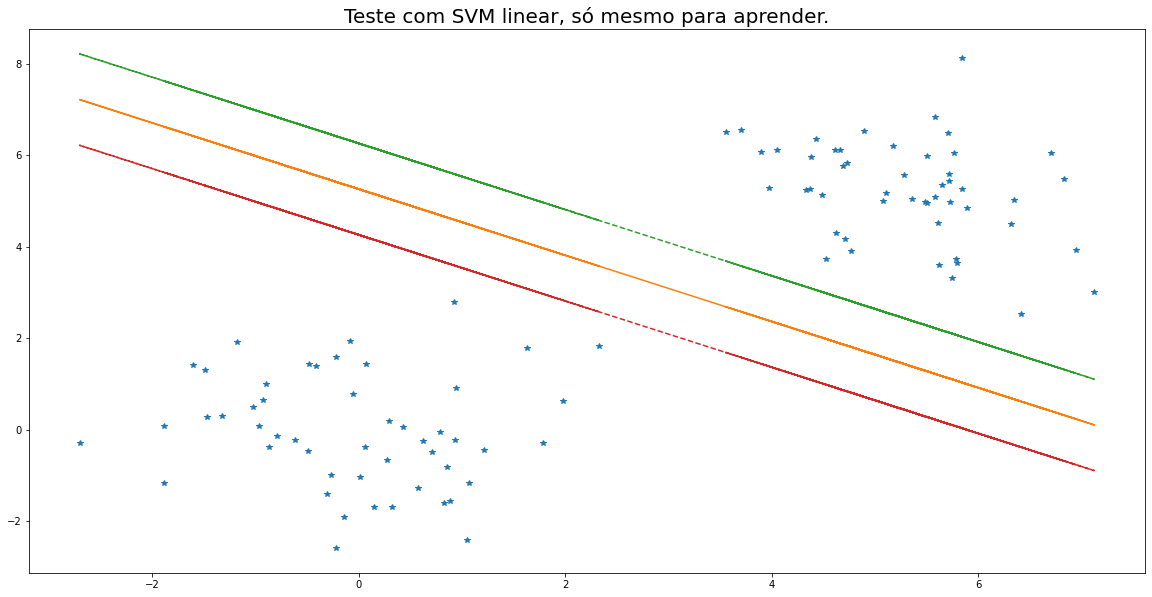

In [62]:
a = [np.random.normal(0,1) for _ in range(50)]
for i in range(50):
    a.append(np.random.normal(5,1))

a2 = [np.random.normal(0,1) for _ in range(50)]
for i in range(50):
    a2.append(np.random.normal(5,1))
amostra_aux = [a,a2]

# 1 - Carregar a base de dados com duas classes
amostra = pd.DataFrame([a,a2]).T

# 2 - Carregar vetor y dos rótulos -1 e +1
y = pd.concat([pd.DataFrame(np.ones([50,1])),pd.DataFrame(-np.ones([50,1]))])
y.reset_index(drop=True,inplace=True)       #100x1

# 3 - Programação quadrática para obter alpha
diag_y = np.identity(y.shape[0],dtype='int')*y.values
B = diag_y @ amostra.values @ amostra.T.values @ diag_y
B += np.identity(y.shape[0],dtype='int')*0.01
b = -np.ones((100))                        
A = np.identity(b.shape[0],dtype='int')*-1    

c = np.zeros((100))                        
Aeq = y.values    
Aeq = Aeq.reshape((100))
beq = np.array([1.])                          

alpha = solve_qp(B, b, A, c, Aeq, beq)

diag_alpha = np.identity(alpha.shape[0],dtype='int')*alpha

# 5 - Calcular o vetor de pesos
w = amostra.T@diag_y@diag_alpha
w = w.sum(axis=1)

# 6 - Encontrar o melhor vetor de suporte
vetores_sup = np.argwhere(alpha>1e-8)
b= 0
for i in vetores_sup:
    b = b + 1/y.iloc[i[0]].values - w.T.values@amostra.iloc[i[0],:].values
b = b/vetores_sup.shape[0]

# 7 - Testar os dados
y_pred = np.sign(w@amostra.T+b[0])

w_div = w[0]/w[1]

vsup_sum_b   = -(w_div * amostra.iloc[:,0].values + b/w[1]) # amostra.iloc[:,1]

plt.figure(figsize=(20,10))
plt.plot(amostra.iloc[:,0],amostra.iloc[:,1],'*')
plt.title('Teste com SVM linear, só mesmo para aprender.',fontsize=20)
plt.plot(amostra.iloc[:,0],vsup_sum_b)
plt.plot(amostra.iloc[:,0],vsup_sum_b+1,'--')
plt.plot(amostra.iloc[:,0],vsup_sum_b-1,'--')

plt.show()

Usei dados aleatórios gaussianos, variando a média e mantendo a variância.

### Carregar a base dados

In [63]:
X_pca,y_pca = PCA(urban_df,limiar=0.9)

Redução de 91.0% na dimensão
Perda de: 0.1628997228732418


Eu ordenei a base dados por classe e normalizei com max-min, além de tudo, reduzi o PCA. Aqui reduzi em 91% a dimensão dos dados e perdir apenas 16% de informação.

### SVM Relaxado: Implementação

In [48]:
def SVM_Relaxado(Treino,teste,C,K_treino,K_teste,classe=1):

    # 1 - Carregar a base de dados com duas classes, retirar a coluna de classe.
    X_class_less = Treino.iloc[:,:-1]
    y_class_less = teste.iloc[:,:-1]
    
    # 2 - Carregar vetor y dos rótulos +1 e -1    
    y_classe_1_menos_1_treino = classe_1_menos_1(Treino,classe) # trenio:nº amostra x 1  shape: (n º amostra,1)
    y_classe_1_menos_1_teste  = classe_1_menos_1(teste,classe)  # teste :nº amostra x 1  shape: (n º amostra,1)
    
    # 3 - Programação quadrática para obter alpha
    diag_y = np.identity(y_classe_1_menos_1_treino.shape[0],dtype='int')*y_classe_1_menos_1_treino.values

    B = (diag_y @ K_treino) @diag_y
    B = ((B + B.T)/2).values
    B += np.identity(B.shape[0],dtype='int')*0.1       # B:   nº amostra x n º amostra  shape: (n º amostra,n º amostra)
    B = B.astype('double')

    b = -C*np.ones((Treino.shape[0]))                  # b:   n º amostra x 1           shape: (n º amostra,)
    A = -np.identity(b.shape[0],dtype='float')         # A:   n º amostra x n º amostra shape: (n º amostra,n º amostra) 
    A = A.astype('double')
    c = np.zeros((Treino.shape[0]))                    # c:   n º amostra x 1           shape: (n º amostra, 1)  
    
    Aeq = y_classe_1_menos_1_treino.T.values           # Aeq: 1 x n º amostra           shape: (n º amostra,)
    beq = np.array([0])                                # beq: 1x1                       shape: (1,)  

    alpha = solve_qp(B, b, A, c, Aeq, beq)             # alpha: n º amostra x 1         shape: (n º amostra,) 

    # 4 - Encontrar os vetores de suporte 
    vetores_sup = np.argwhere(alpha>1e-6)              # vetores_sup: amos reduzido x 1 shape:(n º amostra reduzido,1)

    # 5 - Encontrar o bias
    bias = 0
    for i in vetores_sup[:,0]:
        bias = bias + 1/y_classe_1_menos_1_treino.iloc[i].values[0]
        for ii in vetores_sup[:,0]:
            bias = bias - y_classe_1_menos_1_treino.iloc[ii].values[0]*alpha[ii]*K_treino.iloc[ii,i]
    bias = bias/vetores_sup.shape[0]                  # bias: 1x1                       shape:(1,)

    # 6 - Testar os dados de treino    
    w_t_k_treino = 0
    for ii in vetores_sup[:,0]:
        w_t_k_treino = w_t_k_treino + y_classe_1_menos_1_treino.iloc[ii].values[0]*alpha[ii]*K_treino.iloc[ii,:].values
    
    y_pred_treino = np.sign(w_t_k_treino + b[0])

    # 7 - Testar os dados de teste
    w_t_k_teste = 0
    for ii in vetores_sup[:,0]:
        if ii<K_teste.shape[0]:
            w_t_k_teste = w_t_k_teste + y_classe_1_menos_1_teste.iloc[ii].values[0]*alpha[ii]*K_teste.iloc[ii,:].values
    
    y_pred_teste = np.sign(w_t_k_teste + b[0])

    return 100*acc(y_classe_1_menos_1_treino, y_pred_treino),100*acc(y_classe_1_menos_1_teste, y_pred_teste)

#### SVM LINEAR RELAXADO: Teste
- COM KERNEL LINEAR

In [51]:
K_treino = Kernel_Linear(X_pca.iloc[:,:-1],1)
K_teste  = Kernel_Linear(y_pca.iloc[:,:-1],1)

In [52]:
df_acc = pd.DataFrame(index=['Classe 1','Classe 2','Classe 3','Classe 4','Classe 5','Classe 6','Classe 7','Classe 8','Classe 9']
                     ,columns=[1,10,100,1000,10000,100000,1000000,10000000])
for classes,i in zip([1,2,3,4,5,6,7,8,9],range(9)):
        for C,j in zip([1,10,100,1000,10000,100000,1000000,10000000],range(8)):
                    df_acc.iloc[i,j] = SVM_Relaxado(X_pca,y_pca,C,K_treino,K_teste,classes)
display(df_acc)

,1,10,100,1000,10000,100000,1000000,10000000
Classe 1,"(87.0, 71.0)","(87.0, 71.0)","(87.0, 71.0)","(87.0, 71.0)","(87.0, 71.0)","(87.0, 71.0)","(87.0, 71.0)","(87.0, 71.0)"
Classe 2,"(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)"
Classe 3,"(88.0, 88.0)","(88.0, 88.0)","(88.0, 88.0)","(88.0, 88.0)","(88.0, 88.0)","(88.0, 88.0)","(88.0, 88.0)","(88.0, 88.0)"
Classe 4,"(88.0, 79.0)","(88.0, 79.0)","(88.0, 79.0)","(88.0, 79.0)","(88.0, 79.0)","(88.0, 79.0)","(88.0, 79.0)","(88.0, 79.0)"
Classe 5,"(89.0, 89.0)","(89.0, 89.0)","(89.0, 89.0)","(89.0, 89.0)","(89.0, 89.0)","(89.0, 89.0)","(89.0, 89.0)","(89.0, 89.0)"
Classe 6,"(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)","(88.0, 87.0)"
Classe 7,"(96.0, 90.0)","(96.0, 90.0)","(96.0, 90.0)","(96.0, 90.0)","(96.0, 90.0)","(96.0, 90.0)","(96.0, 90.0)","(96.0, 90.0)"
Classe 8,"(96.0, 92.0)","(96.0, 92.0)","(96.0, 92.0)","(96.0, 92.0)","(96.0, 92.0)","(96.0, 92.0)","(96.0, 92.0)","(96.0, 92.0)"
Classe 9,"(93.0, 66.0)","(93.0, 66.0)","(93.0, 66.0)","(93.0, 66.0)","(93.0, 66.0)","(93.0, 66.0)","(93.0, 66.0)","(93.0, 66.0)"


- COM KERNEL RBF

In [53]:
K_treino = Kernel_RBF(X_pca.iloc[:,:-1],0.01)
K_teste = Kernel_RBF(y_pca.iloc[:,:-1],0.01)

In [ ]:
df_acc = pd.DataFrame(index=['Classe 1','Classe 2','Classe 3','Classe 4','Classe 5','Classe 6','Classe 7','Classe 8','Classe 9']
                     ,columns=[0.001,0.01,0.1,1,10,100])
for classes,i in zip([1,2,3,4,5,6,7,8,9],range(9)):
        for gamma,j in zip([0.001,0.01,0.1,1,10,100],range(6)):
                    df_acc.iloc[i,j] = SVM_Relaxado(X_pca,y_pca,C,K_treino,K_teste,classes)
display(df_acc)

#### SVM NÂO LINEAR RELAXADO
- COM KERNEL LINEAR

In [ ]:
K_treino = Kernel_Linear(X_pca.iloc[:,:-1],1)
K_teste = Kernel_Linear(y_pca.iloc[:,:-1],1)

In [ ]:
df_acc = pd.DataFrame(index=['Classe 1','Classe 2','Classe 3','Classe 4','Classe 5','Classe 6','Classe 7','Classe 8','Classe 9']
                     ,columns=[1,10,100,1000,10000,100000,1000000,10000000])
for classes,i in zip([1,2,3,4,5,6,7,8,9],range(9)):
        for C,j in zip([1,10,100,1000,10000,100000,1000000,10000000],range(8)):
                    df_acc.iloc[i,j] = SVM_Relaxado(X_pca,y_pca,C,K_treino,K_teste,classes)
display(df_acc)

- COM KERNEL RBF

In [ ]:
df_acc = pd.DataFrame(index=['Classe 1','Classe 2','Classe 3','Classe 4','Classe 5','Classe 6','Classe 7','Classe 8','Classe 9']
                     ,columns=[0.001,0.01,0.1,1,10,100])
for classes,i in zip([1,2,3,4,5,6,7,8,9],range(9)):
         for C,j in zip([1,10,100,1000,10000,100000,1000000,10000000],range(8))
                    df_acc.iloc[i,j] = SVM_Relaxado(X_pca,y_pca,C,'RBF',d=None,gamma=gamma,classes)
display(df_acc)